# Python Statistics

## 1. Carregar bibliotecas e funções

In [2]:
# Bibiotecas padrão
import pandas as pd
import numpy as np

## Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp

# Escrever as fórmulas dos modelos
import patsy as pt

# Fator de inflação da variância
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Bibliotecas do scikitlearn para calcular as métricas e fazer a regressão regularizada
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

In [3]:
def desc_null(df, percentiles=False):
  """
  Função para descrição de dados, incluindo colunas de contagem de nulos e porcentagem de nulos em cada variável
  """
  if percentiles is True:
    des = df.describe(datetime_is_numeric=True,
                      percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.99]).T
    des["nullCount"] = df.shape[0] - des["count"]
    des["null%"] = (des["nullCount"] / df.shape[0]) * 100

  else:
    des = df.describe(include='all', 
                      datetime_is_numeric=True).T
    des['nullCount'] = df.shape[0] - des['count']
    des['null%'] = (des['nullCount'] / df.shape[0]) * 100
    
  return des

In [89]:
def cat_filter(df, columns, entries):
  import pandas as pd
  filter = {}
  for col in columns:
    cat = df[col].value_counts().sort_values(ascending=True)
    filter = {x: 'Other' for x in cat[cat < entries].index}
  df.loc[:, col] = df[col].replace(filter).copy()
  df = pd.get_dummies(df, columns=columns, drop_first=True)
  return df

In [30]:
def histplot(data, title=None, xlabel=None, ylabel=None, x=None, y=None, ax=False, nrows=1, ncols=1, figsize=(10, 5), bins=10):
  """
  Fast histplot configuration
  """
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  if ax is True:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    c = 0
    if len(x) < (nrows * ncols):      
      for i in range(nrows):
        for j in range(ncols):
          if i == nrows-1 and j == ncols-1:
            fig.delaxes(axes[nrows-1,ncols-1])
          else:
            sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i,j]).set_ylabel(ylabel)
            c += 1
      
    elif nrows > 1 and ncols > 1:      
      for i in range(nrows):
        for j in range(ncols):
          sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i,j]).set_ylabel(ylabel)
          c += 1
    elif nrows == 1:
      for j in range(ncols):
        sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[j]).set_ylabel(ylabel)
        c += 1
    elif ncols == 1:
      for i in range(nrows):
        sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i]).set_ylabel(ylabel)
        c += 1
    if title is not None:
      fig.suptitle(title)
  
  else:
    plt.figure(figsize=figsize)
    sns.histplot(data=data, x=x, y=y, bins=bins)
    
    if title is not None:
      plt.title(title)
    if xlabel is not None:
      plt.xlabel(xlabel)
    if ylabel is not None:
      plt.ylabel(ylabel)
      

  return plt.show()

In [72]:
def corrplot(data):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 7))

    sns.heatmap(
        data=data.corr(),
        cmap=sns.diverging_palette(230, 20, as_cmap=True),
        vmin=-1,
        vmax=1,
        annot=True,
    )

    return plt.show()

In [45]:
def norm_test(df):
    import scipy as sp
    kStat, kPvalue = sp.stats.kstest(df, 'norm')
    return print(f'kStat: {kStat:.3f} \n'
                 f'Pvalue: {kPvalue:.3f}')
    

In [67]:
def feat_scale(x):
    import numpy as np

    # Calcular a média da variável
    mean = np.mean(x, axis=0)

    # Calcular o desvio padrão amostral da variável
    sigma = np.std(x, axis=0, ddof=1)

    # Realizar o escalonamento
    xnorm = (x - mean) / sigma

    return xnorm

In [5]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

## 2. Carregar os dados

**Database**: https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

Contém informações sobre carros e gasto de combustível

In [6]:
# Database
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

## Nomenclatura das colunas: https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names
cols = ['mpg', 'cyl', 'disp', 'hp', 'weight', 'acc', 'year', 'origin', 'name']

In [7]:
# Read table para visualizar dados delimitados por espaço
df = pd.read_table(url, header=None, 
                   delim_whitespace=True, 
                   names=cols)

In [8]:
df.head()

,mpg,cyl,disp,hp,weight,acc,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## 3. Exploratory Data Analysis - Análise Exploratória de dados

A base de dados não possui valores nulos e possui 398 entradas.

| **Feature**  | **Descrição**                                               | **Tipo**   | **Range**    | **Valores únicos**                              
| :----------: | ----------------------------------------------------------- | :--------: | :----------: | ------------------ 
| mpg          | Quantidade de milhas por galão de gasolina, consumo médio   | Numérico   | 9.0 - 46.6   | 
| cyl          | Quantidade de cilindros no motor do carro                   | Numérico   | 3 - 8        |     
| disp         | Quantidade de força que o motor pode gerar                  | Numérico   | 68  - 455    | 
| hp           | Cavalos de força do motor                                   | Numérico   |              | 94  
| weight       | Peso do veículo (lb/1000)                                   | Numérico   | 1613 - 5140  |  
| acc          | Aceleração                                                  | Numérico   | 8.0 - 24.8   | 
| year         | Ano de fabricação do veículo                                | Categórico | 70 - 82      |
| origin       | Origem do carro:  1. Americano, 2. Europeu e 3. Japones     | Categórico |   1 - 3      | 
| name         | Nome do modelo                                              | Categórico |              | 305

In [9]:
desc_null(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,nullCount,null%
mpg,398.0,NaN,NaN,NaN,23.514573,7.815984,9.0,17.5,23.0,29.0,46.6,0.0,0.0
cyl,398.0,NaN,NaN,NaN,5.454774,1.701004,3.0,4.0,4.0,8.0,8.0,0.0,0.0
disp,398.0,NaN,NaN,NaN,193.425879,104.269838,68.0,104.25,148.5,262.0,455.0,0.0,0.0
hp,398,94,150.0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
weight,398.0,NaN,NaN,NaN,2970.424623,846.841774,1613.0,2223.75,2803.5,3608.0,5140.0,0.0,0.0
acc,398.0,NaN,NaN,NaN,15.56809,2.757689,8.0,13.825,15.5,17.175,24.8,0.0,0.0
year,398.0,NaN,NaN,NaN,76.01005,3.697627,70.0,73.0,76.0,79.0,82.0,0.0,0.0
origin,398.0,NaN,NaN,NaN,1.572864,0.802055,1.0,1.0,1.0,2.0,3.0,0.0,0.0
name,398,305,ford pinto,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


### 3.1. Separação das variáveis

#### 3.1.1. Variáveis categóricas

Separar as variáveis categóricas para análise posterior.

In [10]:
cat = ['year', 'origin', 'name']

for c in cat:
    df[c] = df[c].astype('category')

df[cat].head()

,year,origin,name
0,70,1,chevrolet chevelle malibu
1,70,1,buick skylark 320
2,70,1,plymouth satellite
3,70,1,amc rebel sst
4,70,1,ford torino


#### 3.1.2. Variáveis numéricas

A variável **hp** constava com objeto, sendo necessário trocar o valor **?** por **np.nan** e realizar a conversão para float.

In [11]:
df['hp'].replace(to_replace='?', 
                 value=np.nan, 
                 inplace=True)

df['hp'] = df['hp'].astype('float64')

num = list(df.select_dtypes(include='number'))
num.remove('mpg')

In [12]:
desc_null(df[num], percentiles=True)

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max,nullCount,null%
cyl,398.0,5.454774,1.701004,3.0,4.000,4.000,4.0,8.000,8.0,8.000,8.0,0.0,0.000000
disp,398.0,193.425879,104.269838,68.0,85.000,104.250,148.5,262.000,350.0,440.420,455.0,0.0,0.000000
hp,392.0,104.469388,38.491160,46.0,60.550,75.000,93.5,126.000,157.7,220.450,230.0,6.0,1.507538
weight,398.0,2970.424623,846.841774,1613.0,1923.500,2223.750,2803.5,3608.000,4275.2,4951.030,5140.0,0.0,0.000000
acc,398.0,15.568090,2.757689,8.0,11.285,13.825,15.5,17.175,19.0,22.239,24.8,0.0,0.000000


#### 3.1.3. Variável resposta

In [39]:
resp = 'mpg'

df[resp].head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

### 3.2. Distribuição das variáveis

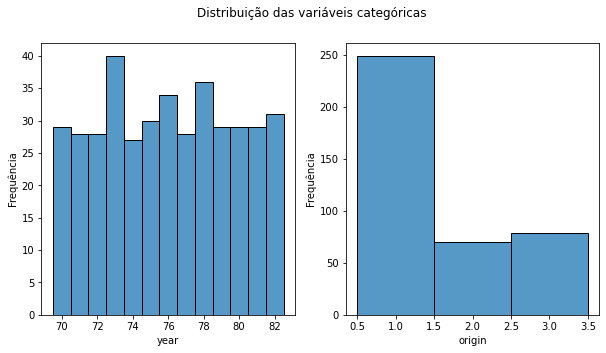

In [26]:
histplot(data=df[cat], 
         title='Distribuição das variáveis categóricas', 
         ylabel='Frequência',
         x=['year', 'origin'], ax=True,
         ncols=2, bins=15,
         figsize=(10,5))

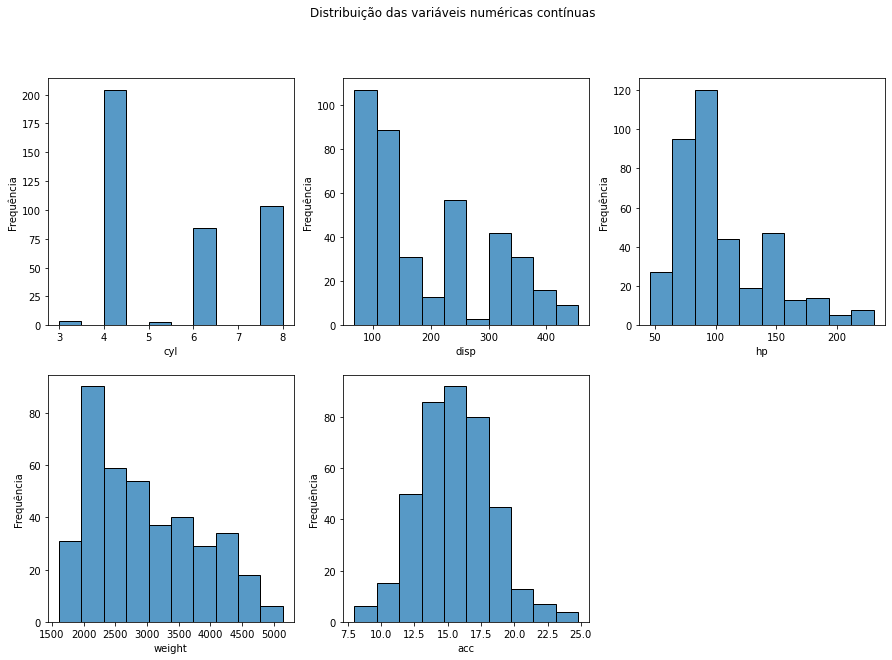

In [32]:
histplot(data=df[num], 
         title='Distribuição das variáveis numéricas contínuas', 
         ylabel='Frequência',
         x=num, ax=True,
         ncols=3, nrows=2,
         figsize=(15,10))

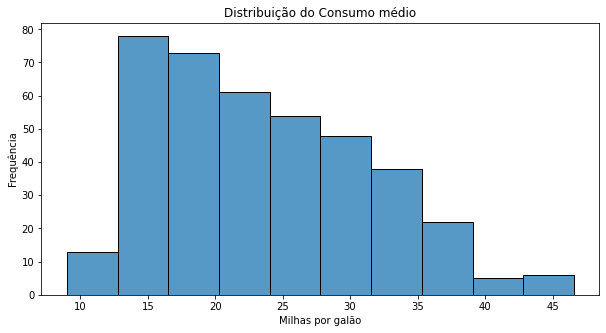

In [40]:
histplot(data=df, x=resp,
         ylabel='Frequência', xlabel='Milhas por galão',
         title='Distribuição do Consumo médio')

A resposta não possui uma distribui distribuição normal e pode dificultar a regressão linear, necessário ser transformada

## 4. Pré Tratamento de dados

### 4.1. Resposta
Antes de realizar uma transformação, realizar um teste de normalidade com o intuito de quantificar o desvio.

In [46]:
norm_test(df[resp])

kStat: 1.000 
Pvalue: 0.000


Como o Pvalue é muito baixo, a resposta deve ser transformada. Uma transformação muito comum para dados assimétricos é a logaritmo natural.
* Atenção, os dados devem ser > 0

#### 4.1.1. Transformação da Resposta - **ln**

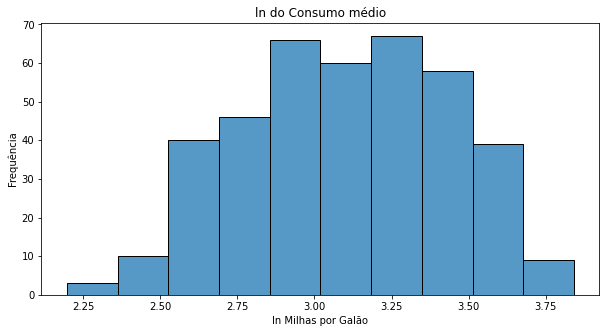

In [48]:
histplot(data=np.log(df[resp]), title='ln do Consumo médio',
         ylabel='Frequência', xlabel='ln Milhas por Galão')

In [49]:
norm_test(np.log(df[resp]))

kStat: 0.987 
Pvalue: 0.000


Apesar de ser mais normalizado, ainda possui uma frequência assimétrica. Apesar do kStat ter melhorado, Pvalue ianda não atingiu o parâmetro necessário.

#### 4.1.2. Transformação Box-Cox
Encontrar um exponente que leva a um desvio padrão menor da resposta - achata o gráfico para que ele se pareça mais com a distribuição normal.

Alpha representa o intervalo de confiança.

In [53]:
boxcox = sp.stats.boxcox(df[resp], alpha=0.01)
print(f'Melhor valor da transformação: {boxcox[1]: .3f} \n'
      f'Intervalo de confiança 99%: {boxcox[2]}')

Melhor valor da transformação:  0.197 
Intervalo de confiança 99%: (-0.18013781883434132, 0.577186423120012)


Com esses resultados, há duas possibilidades:
1. usar o valor do lambda ideal 0.197
2. usar um valor aproximado que está dentro do intervalo de confiança, nesse caso, 0.5 - que representa sua raiz quadrada

##### 4.1.2.1. Lambda ideal 0.197

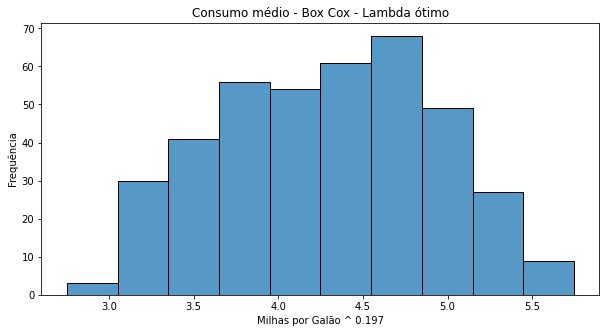

In [54]:
histplot(data=boxcox[0], title='Consumo médio - Box Cox - Lambda ótimo',
         ylabel='Frequência', xlabel='Milhas por Galão ^ 0.197')

In [55]:
norm_test(boxcox[0])

kStat: 0.997 
Pvalue: 0.000


##### 4.1.2.2. Lambda 0.5

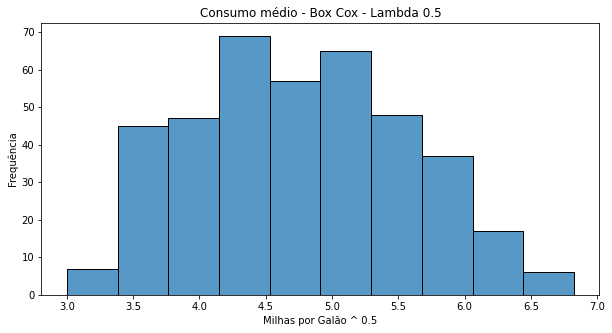

In [56]:
histplot(data=np.sqrt(df[resp]), title='Consumo médio - Box Cox - Lambda 0.5',
         ylabel='Frequência', xlabel='Milhas por Galão ^ 0.5')

In [57]:
norm_test(np.sqrt(df[resp]))

kStat: 0.999 
Pvalue: 0.000


Nenhuma transformada foi capaz de normalizar a resposta numericamente, mas pelo menos diminuiram a assimetria.

Vamos seguir utilizando **ln** pelas seguintes razões:
* é a transformada mais historicamente utilizada, 
* é fácil de converter à escala original **exp(log(y))**
* apresento o menor kStat

In [59]:
yLog = np.log(df[resp])

### 4.2. Variáveis numéricas

In [68]:
xNorm = feat_scale(df[num])

xNorm.head()

,cyl,disp,hp,weight,acc
0,1.496308,1.089233,0.663285,0.630077,-1.293870
1,1.496308,1.501624,1.572585,0.853259,-1.475181
2,1.496308,1.194728,1.182885,0.549778,-1.656492
3,1.496308,1.060461,1.182885,0.546236,-1.293870
4,1.496308,1.041280,0.923085,0.565130,-1.837804


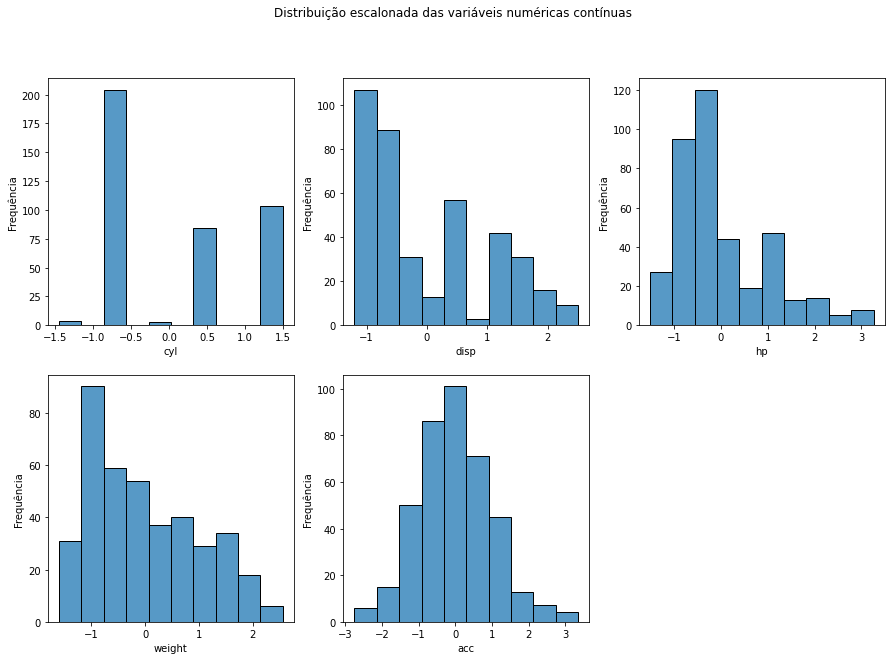

In [63]:
histplot(data=xNorm, 
         title='Distribuição escalonada das variáveis numéricas contínuas', 
         ylabel='Frequência',
         x=num, ax=True,
         ncols=3, nrows=2,
         figsize=(15,10))

O escalonamento não foi capaz de alterar a assimetria das variáveis, elas apenas mudaram de escala. Todos estão com escala numérica similar (-3 a 3) facilitando na comparação dos betas.

In [69]:
np.mean(xNorm)

cyl      -5.065741e-16
disp     -8.256935e-17
hp       -3.231542e-16
weight   -9.637740e-17
acc       5.479704e-15
dtype: float64

In [70]:
np.std(xNorm, ddof=1)

cyl       1.0
disp      1.0
hp        1.0
weight    1.0
acc       1.0
dtype: float64

Agoras as novas variáveis possuem média muito próxima a 0 e desvio padrão de 1

#### 4.2.1. Avaliação da multicolinearidade

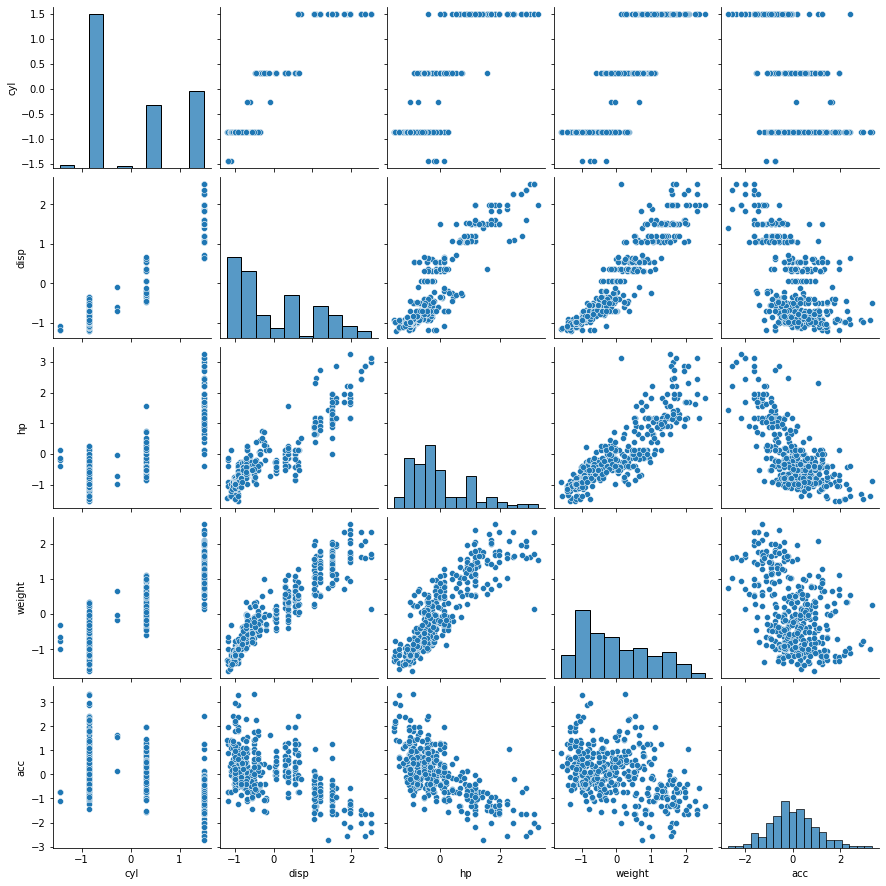

In [71]:
sns.pairplot(xNorm)

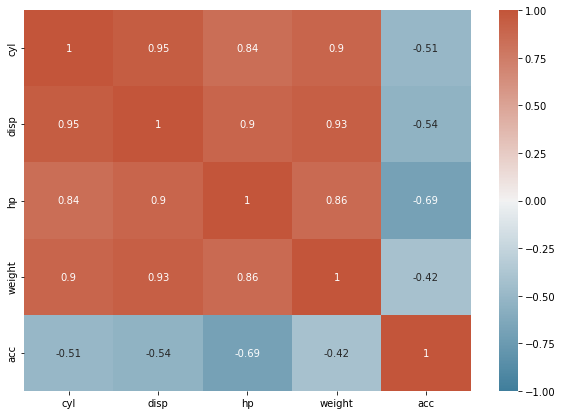

In [73]:
corrplot(xNorm)

Correlações muito altas podem trazer problemas para a modelagem.

### 4.3. Variáveis categóricas

In [90]:
df['brand'] = df['name'].str.split(n=1, expand=True)[0]

cat = ['year', 'origin', 'brand']

In [96]:
xCat = cat_filter(df.loc[:, cat], cat, 8)

xCat.head()

,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,origin_2,origin_3,brand_amc,brand_buick,brand_chevrolet,brand_datsun,brand_dodge,brand_fiat,brand_ford,brand_honda,brand_mazda,brand_mercury,brand_oldsmobile,brand_peugeot,brand_plymouth,brand_pontiac,brand_toyota,brand_volkswagen
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
